# Analyser bøker med en familie ordsekker

In [11]:
import json
import sqlite3
import requests
import pandas as pd
import dask
import pandas as pd
import dhlab.module_update as mu
mu.update('mods_meta')
import mods_meta as mm
import dhlab.nbtext as nb
import re
from IPython.display import Markdown, display
from collections import Counter
from dhlab.nbtokenizer import tokenize
import networkx as nx
import dhlab.graph_networkx_louvain as gnl
import datetime
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import json
mu.update('wordbank')

Updated file `C:\Users\yoons\Documents\GitHub\Trawling\mods_meta.py`

Updated file `C:\Users\yoons\Documents\GitHub\Trawling\wordbank.py`

In [12]:
from wordbank import word_paradigm_many

In [2]:
mu.css()

Set fontsizes for plots etc.

In [4]:
from nb_api_kollokasjon_konk import *

Updated file `C:\Users\yoons\Documents\GitHub\Trawling\mods_meta.py`

Updated file `C:\Users\yoons\Documents\GitHub\Trawling\collocations.py`

In [5]:
def corpus_def(urns):
    metadata = mm.metadata(urns)
    urns = [u for u in metadata if metadata[u] != []]
    return nb.frame({u:metadata[u] for u in urns})

In [6]:
def evaluate(temaer, corpus):
    theme_eval = nb.wordbag_eval(temaer,list(corpus.index))
    # legger til metadata
    result = theme_eval.join(titlestmnt(corpus))
    return result

In [25]:
def declensions(wordbagfamily, pos = None):
    """Set pos to subst, verb or adj for limiting the inflectional forms"""
    if isinstance(pos, list):
        res = {key: list(set([w for infl_set in word_paradigm_many(wordbagfamily[key]) for w in infl_set[2] if infl_set [1] in pos])) for key in wordbagfamily}
    elif isinstance( pos, str):
        res = {key: list(set([w for infl_set in word_paradigm_many(wordbagfamily[key]) for w in infl_set[2] if infl_set [1] == pos])) for key in wordbagfamily}
    else:
        res = {key: list(set([w for infl_set in word_paradigm_many(wordbagfamily[key]) for w in infl_set[2]])) for key in wordbagfamily}
    return res
    
    

In [7]:
titlestmnt = lambda x: pd.DataFrame(x[['245-1-0-a', '245-1-0-b','100-1- -a']])

# Lag familien 

Formen er en samling begreper med markører. De bør helst ikke noe til felles, for å lette tolkning av tellingen.

In [112]:
semantics = {
    'vehicles_': "kjøretøy biler bil".split(),
    'collective_': "fly tog buss trikk kollektivtransport lastebiler".split(),
    'roads_': "vei gate motorvei grusvei fortau".split(),
    'traffic_': "trafikk rushtid trafikk-kaos påsketrafikk".split(),
    'soft_': "fotgjengere gående sykkel sykling".split(),
}

Fyll opp med bøyde former

In [113]:
enriched_semantics = declensions(semantics, pos='subs')

In [114]:
enriched_semantics

{'vehicles_': ['bilen',
  'bil',
  'kjøretøy',
  'biler',
  'bilene',
  'bile',
  'kjøretøyer',
  'kjøretøyene',
  'kjøretøya',
  'kjøretøyet',
  'bila'],
 'collective_': ['bussen',
  'trikkene',
  'lastebilene',
  'trikker',
  'lastebilen',
  'buss',
  'trikken',
  'flyet',
  'tog',
  'flyen',
  'flya',
  'toga',
  'trikk',
  'lastebil',
  'togene',
  'lastebiler',
  'bussene',
  'flyene',
  'flyer',
  'busser',
  'trikka',
  'fly',
  'toget',
  'trikket'],
 'roads_': ['gatene',
  'grusveien',
  'fortauet',
  'vei',
  'gate',
  'motorveier',
  'veiene',
  'veier',
  'grusvei',
  'gata',
  'gaten',
  'veien',
  'motorvei',
  'motorveien',
  'grusveiene',
  'fortaua',
  'fortauer',
  'grusveier',
  'fortauene',
  'motorveiene',
  'gater',
  'fortau'],
 'traffic_': ['trafikk-kaosene',
  'trafikk-kaoser',
  'trafikk-kaoset',
  'trafikker',
  'rushtider',
  'rushtidene',
  'rushtid',
  'trafikk',
  'trafikkene',
  'rushtida',
  'trafikk-kaosa',
  'rushtiden',
  'trafikken',
  'trafikk-kaos

# Definer et korpus ved å sample bøker med metadata

In [144]:
korpus = {yearstart: nb.book_corpus(ddk = '839%', limit = 10000, period = (yearstart, yearstart + 10)) for yearstart in range(1960, 2010, 10)}

# Ta en titt på korpus

In [145]:
korpus [1970].head()

,urn,author,title,year
0,2014041108065,"Wolde, Gunilla",Emmas første dag i barnehagen,1976
1,2014062406025,"Tverbak, Eivind",Med sverd og syndsforlatelse,1977
2,2012062006017,"Ørum, Poul",Natt på venterommet,1974
3,2012022008102,"Asklund, Erik",Gråfugl,1972
4,2014021806167,"Holt, Kåre",Tore Kramkar,1978


In [132]:
korpus2.head()

,urn,author,title,year
0,2007080200053,,Dømt til sikring,1970
1,2011041308130,,Folke- og boligtelling 2001,2003
2,2016101108073,,Norges Industriforbund,1957
3,2014091106110,,Institusjonsliv - et liv uten rettigheter?,1974
4,2007121200079,"Ringstad, Vidar",Samfunnsøkonomi,1994


# Evaluate corpus against categories

In [149]:
korpus_eval = {year: nb.wordbag_eval(enriched_semantics, list(korpus[year].urn)) for year in korpus}

In [135]:
def one(x):
    
    if isinstance(x, (float, int)) and x > 0:
        res = 1
    elif isinstance(x, (float, int)):
        res = 0
    else:
        res = x
    return res

In [136]:
def plotfig(a_plot, font_size = 18):
    fsize = plt.rcParams["font.size"]
    plt.rcParams["font.size"] = font_size
    ax = a_plot
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_color("grey")
    ax.spines["left"].set_color("grey")
    ax.spines["bottom"].set_linewidth(1)
    ax.spines["left"].set_linewidth(1)
    #plt.rcParams["font.size"] = fsize
    return


In [150]:
korpus_eval[1960]

,collective_,roads_,vehicles_,traffic_,soft_,snitt
2011063022001,70.0,515.0,2.0,6.0,0.0,118.6
2007050804012,125.0,232.0,93.0,4.0,23.0,95.4
2007072001084,131.0,165.0,59.0,3.0,3.0,72.2
2007050401075,23.0,106.0,202.0,1.0,12.0,68.8
2007031501086,10.0,19.0,308.0,2.0,4.0,68.6
...,...,...,...,...,...,...
2012052508092,0.0,0.0,1.0,0.0,0.0,0.2
2011031520006,1.0,0.0,0.0,0.0,0.0,0.2
2007073101037,1.0,0.0,0.0,0.0,0.0,0.2
2007031901062,0.0,1.0,0.0,0.0,0.0,0.2


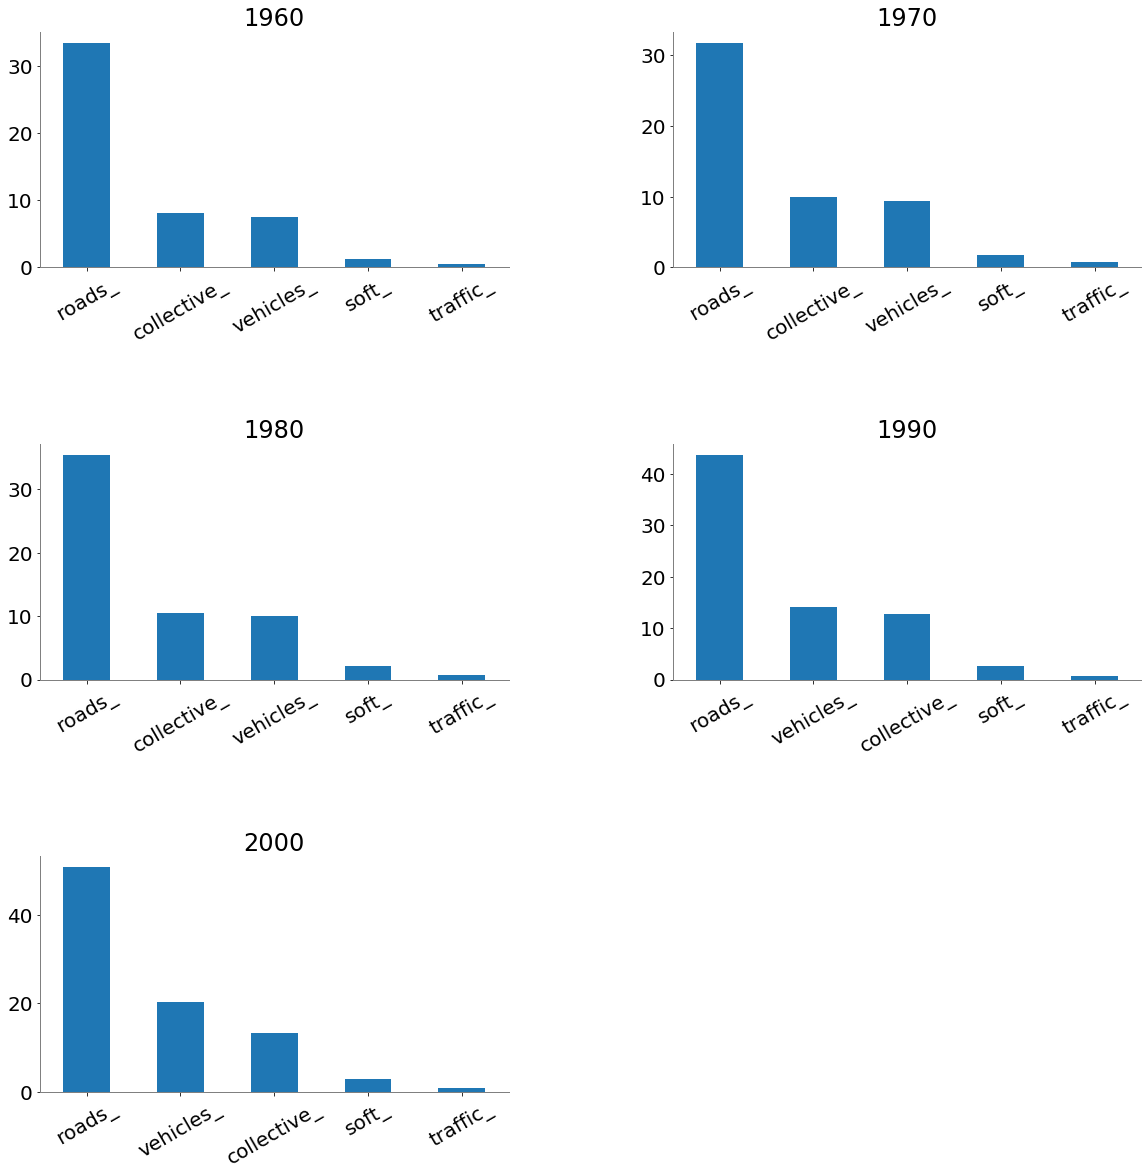

In [204]:
for i,y in enumerate(korpus_eval):
    num = 321 + i
    plt.subplot(num)
    plotfig(korpus_eval[y].mean()[list(semantics.keys())].sort_values(ascending=False).plot(kind='bar', rot=30, figsize=(18,8), title=str(y)),
       font_size = 20) 
plt.subplots_adjust(top=1.92, bottom=0.08, left=0.10, right=0.95, hspace=0.75,
                    wspace=0.35)

In [140]:
def plot_together(A, B, aname = "A", bname = "B", rot = 60):
    df = pd.DataFrame()
    df[aname] = A
    df[bname] = B
    plotfig(df.sort_values(by=aname, ascending=False).plot(kind='bar', rot=60, figsize=(15,5), title="Comparison mean conditional"))
    return

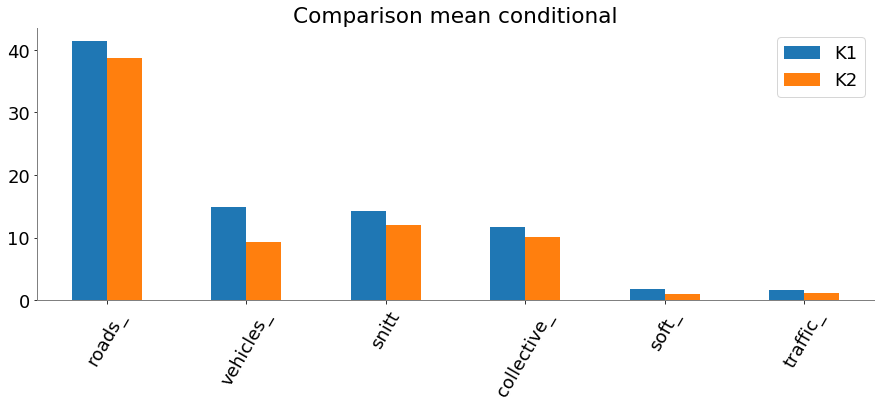

In [141]:
plot_together(korpus1_eval.mean(),
              korpus2_eval.mean(), aname = "K1", bname = "K2")

In [52]:
def cross(df, cols = None):
    if isinstance(cols, (list, object)):
        res = df[cols].transpose().dot(df[cols])
    else:
        res = df.transpose().dot(df)
    return res

In [53]:
def cosine_sims(df):
    """ similarity takes rows, so there must be transpose()"""
    cosines = pd.DataFrame(cosine_similarity(df.transpose()))
    cosines.columns = df.columns
    cosines.index = df.columns
    return cosines
     

In [54]:
def cosine_dists(df):
    """ similarity takes rows, so there must be transpose()"""
    cosines = pd.DataFrame(cosine_distances(df.transpose()))
    cosines.columns = df.columns
    cosines.index = df.columns
    return cosines
     

In [85]:
def show_info(weighted_frame):
    G = nx.from_pandas_adjacency(weighted_frame)
    display(Markdown('### Clusters'))
    gnl.show_graph(G)
    gnl.show_communities(G)
    #display(Markdown('### Central'))
    #display(nb.frame_sort(nb.frame([x for x in nb.central_betweenness_characters(G)])))